# **Simulating Color Blindness**

---

#### **Description**

TODO

#### **Contents**
- [**Part 1:** Predict Colors](#predict)

    - [Loading the Data](#load_data)
    - [Split, Train, Test](#split_train_test)
    - [View Results](#view_results)

        - [Helper Functions](#step1)
        - [Initial Results Comparison](#step2)
        - [Preparing Results for Styling](#step3)
        - [Style and Show Results](#step4)
        
    - [Simulating New Colors](#new_colors)
- [**Part 2:** Assessing Palette Accessibility](#palettes)

    - [Color Difference (&Delta;E)](#color_diff)
    - [Finding Color Difference](#find_delta_e)
    - [Perform Accessibility Test](#accessibility_test)
    - [View Results](#view_results_2)
        - [Data Visualization Demo](#demo)

        

## **Part 1:** Predict Colors   <a name="predict"></a>

---

The goal of the first half of this project is to create and train a model to predict what colors would look like to individuals with different types of color blindness or color vision deficiency.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

### **Loading the Data**    <a name="load_data"></a>

The model will be trained to take in the RGB values of the ***True color*** and produce the RGB values for what it would look like to someone with ***Protanopia***, ***Deuteranopia***, or ***Tritanopia***.

So we want to separate the **true data** from the **other RGB data**. 

In [5]:
# df = pd.read_csv("color_blind_RGB.csv")
url = "https://raw.githubusercontent.com/the-codingschool/TRAIN/main/color_blindness_sim/color_blind_RGB.csv"
df = pd.read_csv(url)

true_data = df[['true_red','true_green','true_blue']].copy()
other_data = df.drop(columns=['true_red', 'true_green', 'true_blue'])

### **Split, Train, Test**  <a name="split_train_test"></a>

Possible sklearn models to use:
* LinearRegression
* DecisionTreeRegressor
* RandomForestRegressor


Feel free to break up `other_data` and train your model on one type of color vision deficiency at a time, make note of whether this affects the performance.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(true_data, other_data, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
pred = reg_model.predict(X_test)

print("R2: " + str(metrics.r2_score(y_test, pred)))
print("MSE: " + str(metrics.mean_squared_error(y_test, pred)))
print("MAE: " + str(metrics.mean_absolute_error(y_test, pred)))

R2: 0.952213879916472
MSE: 236.63232163653115
MAE: 10.624655616329685


### **View Results**    <a name="view_results"></a>



##### **Step 1:** Helper Functions  <a name="step1"></a>

The following functions will help format the output table to be visually digestible:

* `make_hex_col()`: Combines the red, green, and blue columns of a vision type into one hexadecimal code that will be used to color the background of a table cell. Takes a dataframe object and color vision type *(true, prot, deut, trit)* as parameters and returns a list of all the RGB color samples as HEX codes, ready to be added to a dataframe as a new column. This allows the `output_cell_styling` function to show us the exact color of a sample. <br />
To learn more about the process of converting RGB to HEX, see this [infographic](https://drive.google.com/file/d/17SjN9rsOv57Y7V1nECDT1R4lGu2yLHq7/view?usp=sharing).

* `text_color_from_ratio()`: Takes a hex code as a parameter and uses standards set by [WCAG](https://www.w3.org/TR/WCAG21/#contrast-minimum) to determine whether text on top of this hex color should be **black** or **white** for visibility. This function determines the [contrast ratio](https://www.w3.org/TR/WCAG21/#dfn-contrast-ratio) of the input color to white by computing the [relative luminance](https://www.w3.org/TR/WCAG21/#dfn-relative-luminance) of the input color. The contrast ratio will determine whether black or white will stand out better against the background color and can be easily read. To learn more about the math involved, visit any of the linked webpages.

* `output_cell_styling()`: Takes a feature column as a parameter and returns a list of styling instructions for each column value as strings. These styling instructions are CSS ([cascading style sheets](https://www.w3schools.com/css/css_intro.asp)) ***attribute:value*** pairs. The primary attributes to consider are:
    - **Background Color** `background-color` - Accepts hex codes (ex: #012D9C) and some standard [color names](https://developer.mozilla.org/en-US/docs/Web/CSS/named-color) (ex: 'red'). At a glance, the background should show us exactly what the sample color looks like *(hex code)* and the colors of the predicted/actual labels *(word name)*.
    - **Text Color** `color` - Accepts hex codes (ex: #012D9C) and some standard [color names](https://developer.mozilla.org/en-US/docs/Web/CSS/named-color) (ex: 'red'). We want to manipulate the color of the text so that it can be properly seen/read against the background color.
    
    When the name of this function is used as a parameter in this method call `df.style.apply()` it is called on each feature column in `df`.

In [7]:
"""
Combine the RGB features into one hex code for each sample using string formatting.
The model may have predicted some values outside the 0-255 range.
  - Any negative RGB value is set to 0
  - Any RGB value above 255 is set to 255
Return all hex codes as a list so it can be added as a new column to the dataframe.
"""
def make_hex_col(frame, cv_type):
    hex_vals = []
    for index, row in frame.iterrows():
        r = 0 if int(row[cv_type + '_red']) < 0 else 255 if int(row[cv_type + '_red']) > 255 else int(row[cv_type + '_red']) 
        g = 0 if int(row[cv_type + '_green']) < 0 else 255 if int(row[cv_type + '_green']) > 255 else int(row[cv_type + '_green']) 
        b = 0 if int(row[cv_type + '_blue']) < 0 else 255 if int(row[cv_type + '_blue']) > 255 else int(row[cv_type + '_blue']) 
        hex_vals.append(('#%02X%02X%02X' % (r, g, b)))
    return hex_vals

"""
Revert hex color parameter to RGB for contrast ratio analysis.
Dark colors need white text and light colors need black text for appropriate visibility.
Learn more about this process by visiting the resources linked above.
"""
def text_color_from_ratio(hex):
    rgb = matplotlib.colors.to_rgb(hex)
    lum  = (rgb[0] / 12.92 if rgb[0] <= 0.03928 else ( (rgb[0] + 0.055) / 1.055) ** 2.4) * 0.2126
    lum += (rgb[1] / 12.92 if rgb[1] <= 0.03928 else ( (rgb[1] + 0.055) / 1.055) ** 2.4) * 0.7152
    lum += (rgb[2] / 12.92 if rgb[2] <= 0.03928 else ( (rgb[2] + 0.055) / 1.055) ** 2.4) * 0.0722
    ratio = lum if lum > 1 else 5 if lum == 0 else 1/lum
    return 'white' if ratio >= 4.5 else 'black'

"""
For styling hex columns: center-align text, set bg color to hex, and color text for visibility.
"""
def output_cell_styling(column):
    return ['text-align: center; color: ' + text_color_from_ratio(val) + '; background-color: ' + val.lower() for val in column]

##### **Step 2:** Initial Results Comparison    <a name="step2"></a>

Compile the actual and predicted colors for all vision types into a single dataframe for easy side-by-side comparison. The three RGB columns for all of the true/actual/predicted colors should be simplified into one column of hex codes. In total, there should be 7 columns: 1 for true colors and 2 (actual & predicted) for each of the three color vision deficiency types.

However, before calling `make_hex_col()` on any of the predicted data, `pred` must be formatted as a dataframe with the same column names as `y_test`.

From here, you could opt to skip steps 3 & 4 and simply run this line of code to see the results without more advanced styling:

```python
    results_df.style.apply(output_cell_styling)
```

In [8]:
pred_df = pd.DataFrame(pred, columns=y_test.columns)

results_df = pd.DataFrame()
results_df['true'] = make_hex_col(X_test, 'true')
results_df['prot actual'] = make_hex_col(y_test, 'prot')
results_df['prot pred'] = make_hex_col(pred_df, 'prot')
results_df['deut actual'] = make_hex_col(y_test, 'deut')
results_df['deut pred'] = make_hex_col(pred_df, 'deut')
results_df['trit actual'] = make_hex_col(y_test, 'trit')
results_df['trit pred'] = make_hex_col(pred_df, 'trit')

results_df

,true,prot actual,prot pred,deut actual,deut pred,trit actual,trit pred
0,#A3F548,#FADE44,#FFD850,#FFD8A5,#FFCE76,#BDE4F6,#C7D8E9
1,#10C704,#C1AA00,#C49600,#D8A12E,#CA8D2E,#5CB7C6,#3FA8B6
2,#43BDED,#A0ADE3,#8FABD9,#98ADF2,#8EABE5,#2BC1D0,#43C5D4
3,#AA91A9,#9496AB,#92A1AD,#9F93A6,#A09FA7,#A7929D,#A699A4
4,#09435C,#394058,#30474F,#33405E,#33474E,#00474D,#0C4F55
...,...,...,...,...,...,...,...
1006,#BE83DC,#7996EA,#7DA0DF,#8497D4,#8CA0CC,#B1909B,#AD96A1
1007,#52703D,#72673D,#76713D,#7D6343,#816D45,#5C6972,#606E76
1008,#873969,#4A5579,#455D70,#585462,#555C5A,#824348,#7D4A4F
1009,#A73DE2,#006EE5,#346FE3,#0074CA,#4072BC,#8F6870,#876067


##### **Step 3:** Prepare Results for Styling   <a name="step3"></a>

In the end, we want our output table to have two header rows: 
* the top row will separate the columns into the 4 color vision types
* the second row will denote the "Actual" and "Predicted" columns for each type

To do this, we need to add an additional column to the results dataframe to serve as the "Predicted" column for the True color type. This will allow the second line of the following code to properly reformat the columns. Don't worry! This extra column will essentially be removed in Step 4.

In [9]:
results_df.insert(1, 'extra', len(pred)*['#000000'], True)
results_df.columns = columns=pd.MultiIndex.from_product([['True', 'Protanopia', 'Deuteranopia', 'Tritanopia'],['Actual', 'Predicted']])

##### **Step 4:** Style and Show Results    <a name="step4"></a>

In order, the following code block applies these styling steps to the output table:

* Apply background and text coloring to all table cells.
* Hide the extra "True, Predicted" column added in Step 3.
* Center all of the table's heading and subheading text.
* Add small column separation between the 4 vision types. *(this may not appear in all editors)*


When run in an appropriate notebook environment (Google Colab, VSCode, etc), the resulting output table should be easy to read/understand (and even more visually appealing!). See the [pandas documentation](https://pandas.pydata.org/docs/user_guide/style.html) to learn more about table visualization and styling.

In [66]:
results_df.style.apply(output_cell_styling) \
    .hide([('True', 'Predicted')], axis="columns") \
    .set_table_styles([{'selector': 'th', 'props': 'text-align: center;'}], overwrite=False) \
    .set_table_styles({(x, 'Actual'): [{'selector': 'td, th', 'props': 'border-left: 4px solid #d5d5d5;'}] for x in ['Protanopia', 'Deuteranopia', 'Tritanopia']}, overwrite=False)

### **Simulating New Colors**   <a name="new_colors"></a>

Now that you have a trained model, try testing it on your own RGB colors to predict how they might look to individuals with color blindness. 

* **Step 1:** Create a list of your colors in RGB format (these are the 'true' colors). Then, format the list into a DataFrame with proper column names.

* **Step 2:** Perform a prediction on your test data using your regression model. Reformat the prediction data into a DataFrame with proper column names (Remember, this is necessary to create hex columns for the output table).

* **Step 3:** Create a new DataFrame and add hex color columns of all 4 vision types. Again, this will allow you to view all of the predicted colors side-by-side.

* **Step 4:** Apply cell styling to the DataFrame table.


In [30]:
# Step 1
my_colors = [[109, 199, 44], [163, 91, 168], [211, 34, 72], [220, 54, 126], [0, 64, 158]]
my_X_test = pd.DataFrame(my_colors, columns=X_test.columns)

# Step 2
my_pred = reg_model.predict(my_X_test)
my_pred = pd.DataFrame(my_pred, columns=y_test.columns)

# Step 3
my_results_df = pd.DataFrame()
my_results_df['True'] = make_hex_col(my_X_test, 'true')
my_results_df['Protanopia'] = make_hex_col(my_pred, 'prot')
my_results_df['Deuteranopia'] = make_hex_col(my_pred, 'deut')
my_results_df['Tritanopia'] = make_hex_col(my_pred, 'trit')

# Step 4
my_results_df.style.apply(output_cell_styling)

,True,Protanopia,Deuteranopia,Tritanopia
0,#6DC72C,#D3AD2F,#E1A451,#8FAFBD
1,#A35BA8,#5D7DAD,#6C7D96,#946F76
2,#D32248,#4B5D5F,#665B3C,#C63437
3,#DC367E,#537091,#6C6E6D,#C94C51
4,#00409E,#1B488A,#194A80,#00565D


## **Part 2:** Assess Color Palette Accessibility  <a name="palettes"></a>

---

When selecting a single color, like a background color or a text color, it's relatively straightforward to choose one that is easily distinguishable and readable. However, the challenge arises when attempting to pick multiple colors to form a palette, such as for a website design, data visualization, or artwork.

Imagine you're designing a chart with multiple data series, each represented by a different color. If you use a palette that includes shades of red and green to differentiate between the series, someone with red-green color blindness may struggle to distinguish between them. This can lead to confusion and difficulty interpreting the information presented.

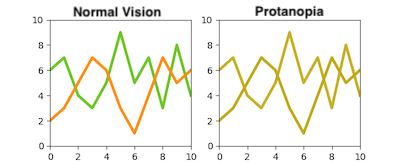

See [Confusion Lines](https://www.color-blindness.com/2009/01/19/colorblind-colors-of-confusion/) to learn more about how certain colors become indistinguishable to people with color vision deficiency.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Color_Blind_Confusion_Lines.png" width="350" />

### **Color Difference**    <a name="color_diff"></a>

Oftentimes, designers will simply use [contrast ratio](https://www.w3.org/TR/WCAG21/#dfn-contrast-ratio) to ensure the colors in their palettes can be differentiated by anyone. Selecting high contrast colors will usually allow even those with \*[Achromatopsia](#achromatopsia) to differentiate colors based on how light or dark they appear. However, this method can be rather restrictive since there are colors with low contrast that are still easily distinguishable by those with either protanopia, deuteranopia, or tritanopia.

Another way to ensure palette accessibility with fewer limitations is by using **Color Difference**!

**Color Difference**, otherwise referred to as **color distance** or **Delta E (&Delta;E)**, is a metric used to quantify the difference between two colors. It is a measure of how distinguishable two colors are from each other. Color difference (&Delta;E) values are commonly used in various industries such as printing, textiles, and manufacturing to ensure consistency and accuracy in color reproduction. This means that **&Delta;E can also be used to evaluate the performance of the model created in Part 1** by finding the distance between the predicted and actual values! In this instance, a lower &Delta;E is better and indicates a more accurate prediction.

Delta E is measured on a scale from 0 to 100. The higher the &Delta;E value, the greater the perceived difference between the two colors. In general, a &Delta;E value below 1 is considered imperceptible to the human eye, while values between 1 and 2 are barely perceptible. Values above 2 indicate noticeable differences, and values above 10 are typically considered to represent very noticeable differences. 


| Color 1 | Color 2 | Color Difference (&Delta;E) |
| ------- | ------- | --------------------------: |
| **#FFFFFF** (white) | **#000000** (black) | **~100.000** |
| **<font color="#DB54F0">#DB54F0</font>** (fuchsia) | **<font color="#DB54F0">#DB54F0</font>** (fuchsia) | **0.000** |


As you can see, &Delta;E of black and white is ~100 since the two colors are essentially opposites, while &Delta;E of two instances of the same exact color is 0.

***But why does knowing this help us?***

As previously mentioned, having a type of red-green color blindness (protanopia or deuteranopia) makes it difficult to distinguish certain shades of red, orange, brown, green, etc. While this **<font color="#6DC72C">green</font>** color may look completely different from this **<font color="#FF8E00">orange</font>** color to those with normal vision, they end up looking nearly identical to those with either protanopia or deuteranopia. So even though a combination of these two colors is acceptable for some, it is not accessible to everyone. 

The table below demonstrates how dramatically &Delta;E changes depending on the vision type.


| Vision Type | Color 1 | Color 2 | Color Difference (&Delta;E) | Accessibility |
| ----------- | ------- | ------- | --------------------------: | :-----------: |
| True        | **<font color="#6DC72C">#6DC72C</font>** (green) | **<font color="#FF8E00">#FF8E00</font>** (orange) | **47.851** | Great |
| Protanopia  | **<font color="#C7B02B">#C7B02B</font>** (muddy yellow) | **<font color="#C0AA13">#C0AA13</font>** (muddy yellow) |  **2.035** | Poor  |
| Deuteranopia| **<font color="#DEA73E">#DEA73E</font>** (yellow-orange) | **<font color="#D8A100">#D8A100</font>** (yellow-orange) |  **4.217** | Poor  |
| Tritanopia  | **<font color="#88B8C6">#88B8C6</font>** (light blue) | **<font color="#FF868E">#FF868E</font>** (coral pink) | **44.656** | Great |


Here is a different example of two colors that most people can differentiate, but are practically indistinguishable to those with blue-yellow color blindness (tritanopia).


| Vision Type | Color 1 | Color 2 | Color Difference (&Delta;E) | Accessibility |
| ----------- | ------- | ------- | --------------------------: | :-----------: |
| True        | **<font color="#F986A0">#F986A0</font>** (pink) | **<font color="#FF8E00">#FF8E00</font>** (orange) | **35.946** | Good  |
| Protanopia  | **<font color="#A8A7B0">#A8A7B0</font>** (bluish gray) | **<font color="#C0AA13">#C0AA13</font>** (muddy yellow) | **33.458** | Good  |
| Deuteranopia| **<font color="#BFA297">#BFA297</font>** (pinkish gray) | **<font color="#D8A100">#D8A100</font>** (yellow-orange) | **24.641** | Okay  |
| Tritanopia  | **<font color="#F78791">#F78791</font>** (coral pink) | **<font color="#FF868E">#FF868E</font>** (coral pink) |  **1.736** | Poor  |


<a name="achromatopsia"></a> *<span style="font-size: small"> *Achromatopsia - Sees no color at all, only black, gray, and white. It is rarest form of color blindness.</span>*

---


#### **Your Task** 

The goal of **Part 2** is to be able to assess whether a palette of colors passes an accessibility test for all 4 vision types. After using your model to predict the *prot.,* *deut.,* and *trit.* equivalents to a given set of *true colors*, find &Delta;E of every pair of colors in each collection. If &Delta;E is above a certain threshold or tolerance level for every possible pair, the palette passes for that vision type. You get to decide the tolerance threshold, the default is 10. The higher the tolerance threshold is, the harder it will be to pass but the more accessible your results will end up being. A palette is only truly accessible if it passes for *true*, *prot.*, *deut.*, and *trit.*

---

### **Finding Color Difference (&Delta;E)**     <a name="find_delta_e"></a>

There are several ways to calculate color difference. Many of these methods have been outlined by the International Commission on Illumination (CIE), whose most recent and arguably most accurate implementation being **CIEDE2000** (also called CIE2000). Determining &Delta;E from the CIEDE2000 definition of color distance is a mathematically intense process that involves more than a dozen formulas. The entire process can be found [here](https://hajim.rochester.edu/ece/sites/gsharma/ciede2000/ciede2000noteCRNA.pdf).

Fortunately, there is a python library that we can use to calculate &Delta;E from the CIEDE2000 method. It is called `colormath` and must first be installed by running the following line of code.

In [ ]:
!pip install colormath

In [11]:
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import _get_lab_color1_vector, _get_lab_color2_matrix
from colormath import color_diff_matrix

def delta_e_cie2000(color1, color2, Kl=1, Kc=1, Kh=1):
    """
    Calculates the Delta E (CIE2000) of two colors (as LabColor objects).

    This function already exists in the colormath.color_diff library 
    however, it attempts to use an outdated numpy method that causes an error
    so it has been rewritten here without the faulty code.
    """
    color1_vector = _get_lab_color1_vector(color1)
    color2_matrix = _get_lab_color2_matrix(color2)
    delta_e = color_diff_matrix.delta_e_cie2000(color1_vector, color2_matrix, Kl=Kl, Kc=Kc, Kh=Kh)[0]
    return delta_e


def find_color_diff(hex1, hex2):
    """
    Converts two hex colors to sRGB and then to Lab format before starting CIEDE2000.
    """
    rgb1 = sRGBColor.new_from_rgb_hex(hex1)
    rgb2 = sRGBColor.new_from_rgb_hex(hex2)
    lab1 = convert_color(rgb1, LabColor)
    lab2 = convert_color(rgb2, LabColor)
    return delta_e_cie2000(lab1, lab2)


def is_palette_accessible(color_list=[], tolerance=10):
    """
    Compares each color to the other colors in the list.
    Returns True if delta_e for all pairs is >=tolerance.
    Creates & returns 3 lists to be used as columns when viewing the accessibility test results for each vision type.
    """
    is_accessible = True
    col1 = []
    col2 = []
    diff = []
    for i in range(len(color_list)):
        for j in range(i + 1, len(color_list)):
            delta_e = find_color_diff(color_list[i], color_list[j])
            is_accessible = is_accessible and delta_e >= tolerance
            col1.append(color_list[i])
            col2.append(color_list[j])
            diff.append(delta_e)

    return is_accessible, col1, col2, diff

### **Perform Accessibility Test & Record Results**     <a name="accessibility_test"></a>

This code block reuses the same colors and resulting DataFrame object from the end of Part 1, but feel free to make your own palette with any number of colors and create a new DataFrame by following the steps in ***Part 1: Simulating New Colors***.

In [12]:
# adjust the tolerance_threshold value as desired
# a higher tolerance means the colors need to have greater distance to pass as accessible
tolerance_threshold = 10

accessible_all_types = True
pass_fail = []                  # records whether each test passed or failed
comparison_tables = {}          # saves the test details for each vision type
for vision_type, color_list in my_results_df.items():
    accessible, col1, col2, diff = is_palette_accessible(color_list, tolerance_threshold)
    pass_fail.append('Pass' if accessible else 'Fail')
    accessible_all_types = accessible_all_types and accessible
    comparison_tables[vision_type] = pd.DataFrame({'col1': col1, 'col2': col2, 'difference': diff})

print('Is the selected palette accessible to all 4 vision types? ', accessible_all_types)

Is the selected palette accessible to all 4 vision types?  False


### **View Results**    <a name="view_results_2"></a>

In [13]:
"""
Expanded version of the output_cell_styling() function from Part 1.

Styles Pass/Fail cells to have green/red text.
Colors the text red in the difference column if the value is under the set tolerance level.
"""
def color_comparison_styling(column, tolerance=10):
    if column.name == 'difference':
        return ['color: red' if val < tolerance else 'color: default' for val in column]
    
    return ['text-align: center; color: ' + text_color_from_ratio(val) + '; background-color: ' + val if val[0] == '#' else \
            'text-align: center; font-weight: bold; color: green' if val == 'Pass' else \
            'text-align: center; font-weight: bold; color: red' for val in column]

In [14]:
"""
Add the pass_fail list to be the final row.
Style and display a summary of the accessibility tests.
"""
results_copy = my_results_df.copy()   
results_copy.loc[-1] = pass_fail
results_copy.style.apply(color_comparison_styling, tolerance=tolerance_threshold)

,True,Protanopia,Deuteranopia,Tritanopia
0,#6DC72C,#D3AD2F,#E1A451,#8FAFBD
1,#A35BA8,#5D7DAD,#6C7D96,#946F76
2,#D32248,#4B5D5F,#665B3C,#C63437
3,#DC367E,#537091,#6C6E6D,#C94C51
-1,Pass,Fail,Pass,Fail


In [15]:
"""
Style and display the saved test details as individual tables for each vision type.
"""
for vision_type, table in comparison_tables.items():
    styled_table = table.style.apply(color_comparison_styling) \
        .set_caption(vision_type) \
        .set_table_styles([
            {'selector': 'caption', 'props': 'font-size: large; font-weight: bold; margin-top: 20px;'}, 
            {'selector': 'td', 'props': 'border-bottom: 4px solid #404040'}
        ])
    
    display(styled_table)

,col1,col2,difference
0,#6DC72C,#A35BA8,79.624608
1,#6DC72C,#D32248,78.042567
2,#6DC72C,#DC367E,82.727373
3,#A35BA8,#D32248,25.292778
4,#A35BA8,#DC367E,15.931108
5,#D32248,#DC367E,12.740143


,col1,col2,difference
0,#D3AD2F,#5D7DAD,49.877837
1,#D3AD2F,#4B5D5F,44.547550
2,#D3AD2F,#537091,52.818245
3,#5D7DAD,#4B5D5F,21.263491
4,#5D7DAD,#537091,6.302542
5,#4B5D5F,#537091,15.005199


,col1,col2,difference
0,#E1A451,#6C7D96,39.795078
1,#E1A451,#665B3C,34.155868
2,#E1A451,#6C6E6D,33.542821
3,#6C7D96,#665B3C,30.414373
4,#6C7D96,#6C6E6D,13.179862
5,#665B3C,#6C6E6D,14.999817


,col1,col2,difference
0,#8FAFBD,#946F76,35.251176
1,#8FAFBD,#C63437,47.799451
2,#8FAFBD,#C94C51,43.984672
3,#946F76,#C63437,20.244424
4,#946F76,#C94C51,16.465529
5,#C63437,#C94C51,6.042396


#### **Data Visualization Demo**     <a name="demo"></a>

It's time to see these colors in action!

Create some basic subplots to visualize how your selected color palette will appear to each of the vision types. Use this exercise to make the ultimate decision of whether or not the palette is accessible. If some palettes were able to pass the accessibility test but still look confusing when plotted, try adjusting the `tolerance_threshold`, switching out some colors, and running the test again.

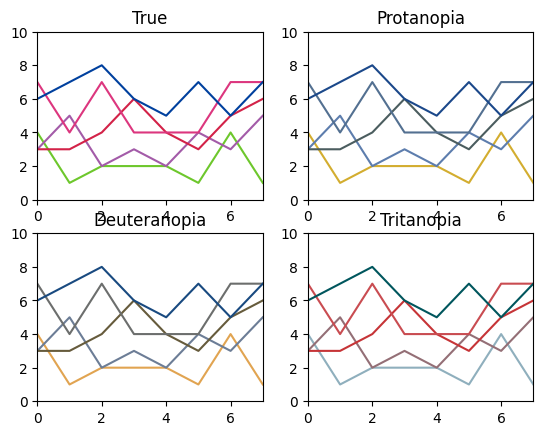

In [48]:
from random import randint

"""
Generate semi-random points to plot for each color in the original palette.
These points will be reused to make identical subplots for each vision type
"""
x_data = range(8)
y_data = []
for i in range(len(my_results_df['True'])):
    y_data.append([randint(1+i,4+i) for j in x_data])   # using randint(1+i,4+i) helps keep the plots from looking too messy

count = 0
for vision_type, color_list in my_results_df.items():
    count += 1
    plt.subplot(2,2,count)
    plt.xlim(0, 7)
    plt.ylim(0, 2*len(color_list))
    plt.title(vision_type)

    for i in range(len(color_list)):
        plt.plot(x_data, y_data[i], c=color_list[i])

plt.show()